# Data Preparation

In [1]:
import numpy as np
import pandas as pd

In [2]:
data= pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

In [3]:
data.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [4]:
data.Time

0              0.0
1              0.0
2              1.0
3              1.0
4              2.0
            ...   
284802    172786.0
284803    172787.0
284804    172788.0
284805    172788.0
284806    172792.0
Name: Time, Length: 284807, dtype: float64

In [5]:
data.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [6]:
data.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

So far, no null value and data is imbalanced

In [7]:
from sklearn.preprocessing import RobustScaler

rob_scaler = RobustScaler()

data['Amount'] = rob_scaler.fit_transform(data['Amount'].values.reshape(-1,1))
data['Time'] = rob_scaler.fit_transform(data['Time'].values.reshape(-1,1))

In [8]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.25, random_state=0)

features_train = train.drop(['Class'], axis=1)
target_train = train['Class']

features_test = test.drop(['Class'], axis=1)
target_test = test['Class']

In [9]:
features_train.shape, target_train.shape, features_test.shape, target_test.shape

((213605, 30), (213605,), (71202, 30), (71202,))

# LR

## Using normal data

In [10]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='saga')
lr.fit(features_train, target_train)

lr_predict = lr.predict(features_test)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [11]:
from sklearn.metrics import recall_score

recall_score(target_test, lr_predict)

0.6083333333333333

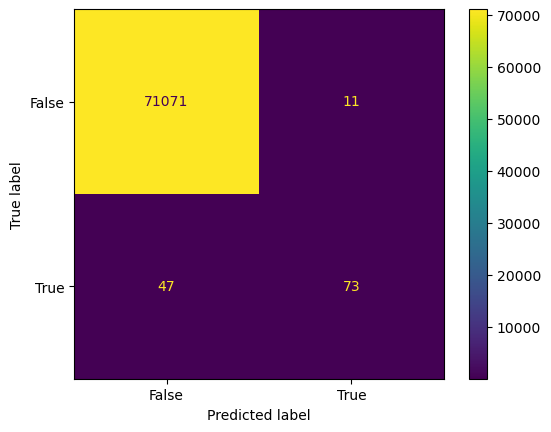

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

conf = confusion_matrix(target_test, lr_predict)

cm_display = ConfusionMatrixDisplay(confusion_matrix = conf, display_labels = [False, True])

cm_display.plot()
plt.show() 

In [13]:
# using another solver

lr = LogisticRegression(solver='liblinear')
lr.fit(features_train, target_train)

lr_predict = lr.predict(features_test)

In [14]:
recall_score(target_test, lr_predict)

0.6583333333333333

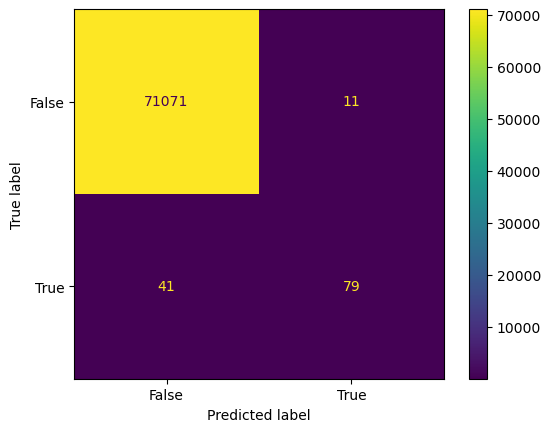

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

conf = confusion_matrix(target_test, lr_predict)

cm_display = ConfusionMatrixDisplay(confusion_matrix = conf, display_labels = [False, True])

cm_display.plot()
plt.show() 

In summary, based on the confusion matrix:

- The model correctly predicted the positive class (TP) 71,071 times.
- The model correctly predicted the negative class (TN) 79 times.
- The model incorrectly predicted the positive class (FP) 11 times.
- The model incorrectly predicted the negative class (FN) 41 times.

With recall score = 0.6583

Clearly this is a low score, it is because of the model or the data itself courtesy of data imbalance. We'll try downsample for the next one

## Using downsampled data

In [16]:
# try downsample to fix the data imbalance

fraud = data[data['Class'] == 1]
non_fraud = data[data['Class'] == 0]

fraud.Class.value_counts(), non_fraud.Class.value_counts()

(1    492
 Name: Class, dtype: int64,
 0    284315
 Name: Class, dtype: int64)

In [17]:
non_fraud_sample = non_fraud.sample(n=492)

down_data = pd.concat([fraud, non_fraud_sample], axis=0)

down_data.shape, type(down_data)

((984, 31), pandas.core.frame.DataFrame)

In [18]:
train_down, test_down = train_test_split(down_data, test_size=0.25, random_state=0)

features_train_down = train_down.drop(['Class'], axis=1)
target_train_down = train_down['Class']

features_test_down = test_down.drop(['Class'], axis=1)
target_test_down = test_down['Class']

In [19]:
features_train_down.shape, target_train_down.shape, features_test_down.shape, target_test_down.shape

((738, 30), (738,), (246, 30), (246,))

In [20]:
target_test_down.value_counts(), target_train_down.value_counts()

(0    127
 1    119
 Name: Class, dtype: int64,
 1    373
 0    365
 Name: Class, dtype: int64)

In [21]:
# build model based on downsampled data

lr = LogisticRegression(solver='liblinear')
lr.fit(features_train_down, target_train_down)

lr_predict = lr.predict(features_test_down)
recall_score(target_test_down, lr_predict)

0.9495798319327731

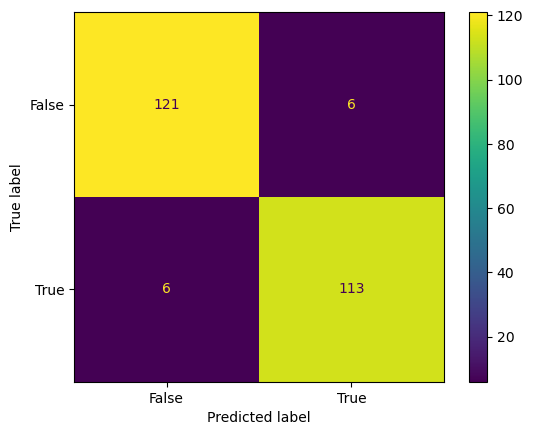

In [22]:
conf = confusion_matrix(target_test_down, lr_predict)

cm_display = ConfusionMatrixDisplay(confusion_matrix = conf, display_labels = [False, True])

cm_display.plot()
plt.show() 

In summary, based on the confusion matrix:

- The model correctly predicted the positive class (TP) 125 times.
- The model correctly predicted the negative class (TN) 112 times.
- The model incorrectly predicted the positive class (FP) 2 times.
- The model incorrectly predicted the negative class (FN) 7 times.

This is way better than the previous model we build with recall score = 0.9411

# Random Forest

## Using normal data

In [23]:
# using normal data

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [5, 10, 20],
    'max_depth': [3, 6]
}

rf = RandomForestClassifier()
grid_clf = GridSearchCV(rf, param_grid, cv=5)
grid_clf.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 6], 'n_estimators': [5, 10, 20]})

In [24]:
#grid_clf.best_estimator_
grid_clf.best_params_
#grid_clf.cv_results_

{'max_depth': 6, 'n_estimators': 10}

In [25]:
# model fit 'max_depth': 6, 'n_estimators': 10


rf = RandomForestClassifier(max_depth=6, n_estimators=10, verbose=2)
rf.fit(features_train, target_train)
rf_predict = rf.predict(features_test)

recall_score(target_test, rf_predict)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


0.725

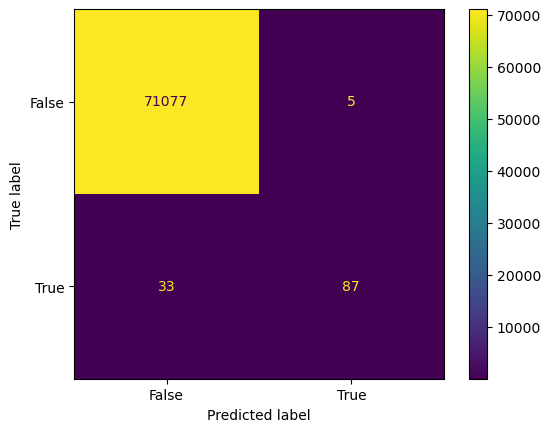

In [26]:
conf = confusion_matrix(target_test, rf_predict)

cm_display = ConfusionMatrixDisplay(confusion_matrix = conf, display_labels = [False, True])

cm_display.plot()
plt.show() 

Slightly better than LR without downsample

## Using downsampled data

In [27]:
# rf using downsampled data

rf = RandomForestClassifier()
grid_clf = GridSearchCV(rf, param_grid, cv=5)
grid_clf.fit(features_train_down, target_train_down)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 6], 'n_estimators': [5, 10, 20]})

In [28]:
grid_clf.best_params_

{'max_depth': 3, 'n_estimators': 10}

In [29]:
rf = RandomForestClassifier(max_depth=6, n_estimators=10, verbose=2)
rf.fit(features_train_down, target_train_down)
rf_predict = rf.predict(features_test_down)

recall_score(target_test_down, rf_predict)

building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


0.8991596638655462

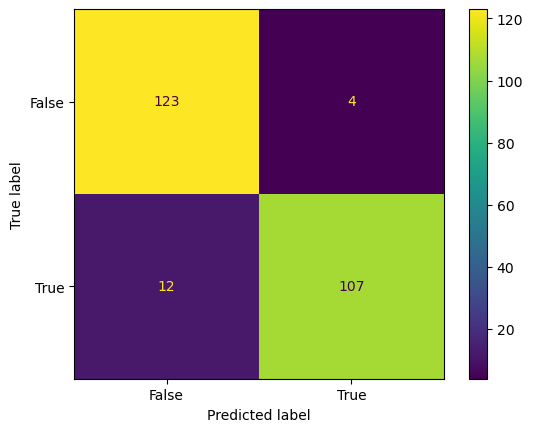

In [30]:
conf = confusion_matrix(target_test_down, rf_predict)

cm_display = ConfusionMatrixDisplay(confusion_matrix = conf, display_labels = [False, True])

cm_display.plot()
plt.show() 

# XGBoost

## Using normal data

In [31]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(features_train, target_train)
xgb_predict = xgb.predict(features_test)

recall_score(target_test, xgb_predict)


0.8

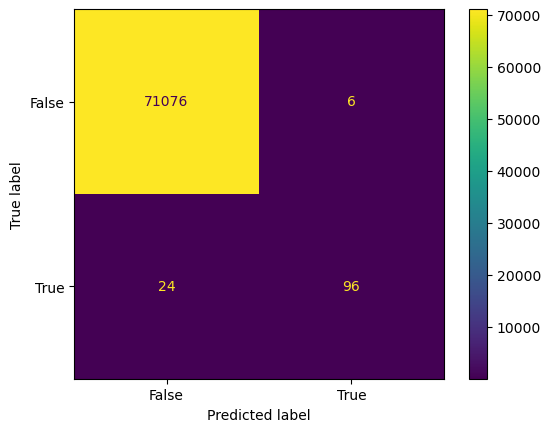

In [32]:
conf = confusion_matrix(target_test, xgb_predict)

cm_display = ConfusionMatrixDisplay(confusion_matrix = conf, display_labels = [False, True])

cm_display.plot()
plt.show() 

This model has best recall score and True Negative score of all the other model without downsample

## Using downsampled data

In [33]:
xgb = XGBClassifier()
xgb.fit(features_train_down, target_train_down)
xgb_predict = xgb.predict(features_test_down)

recall_score(target_test_down, xgb_predict)

0.9495798319327731

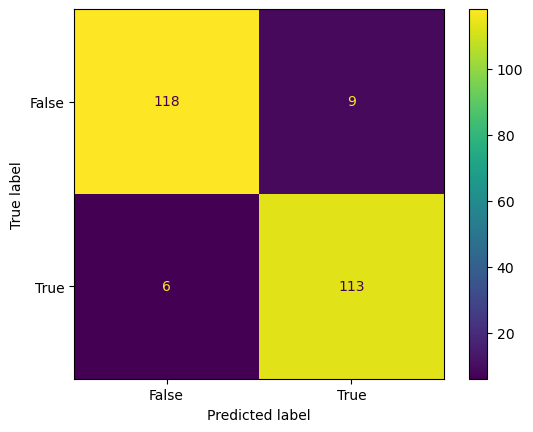

In [34]:
conf = confusion_matrix(target_test_down, xgb_predict)

cm_display = ConfusionMatrixDisplay(confusion_matrix = conf, display_labels = [False, True])

cm_display.plot()
plt.show() 